In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt

import shannonUtils

sns.set_theme()

In [2]:
from shannonUtils import initModel, investmentModelCash

<AxesSubplot:title={'center':'Random walk, 50% chance to double (100% return), 50% chance to half (-50% return)'}, xlabel='time', ylabel='value'>

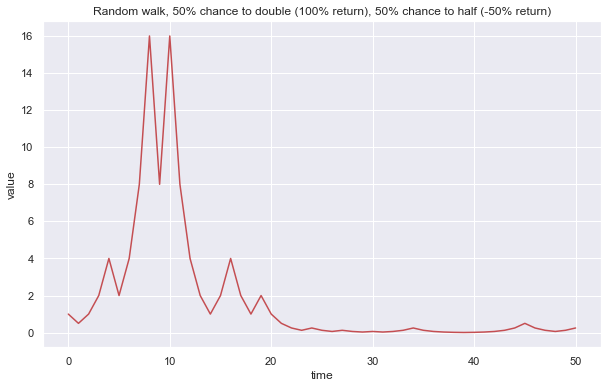

In [3]:
resArr = initModel(50,1,0.5)
pd.Series(resArr).plot(kind='line',figsize=(10,6),
                       title='Random walk, 50% chance to double (100% return), 50% chance to half (-50% return)',
                       xlabel='time',ylabel='value',color=['r'])

In [4]:
outDf = investmentModelCash(0.5,resArr)

<AxesSubplot:title={'center':'cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio'}, xlabel='time', ylabel='cumulative return'>

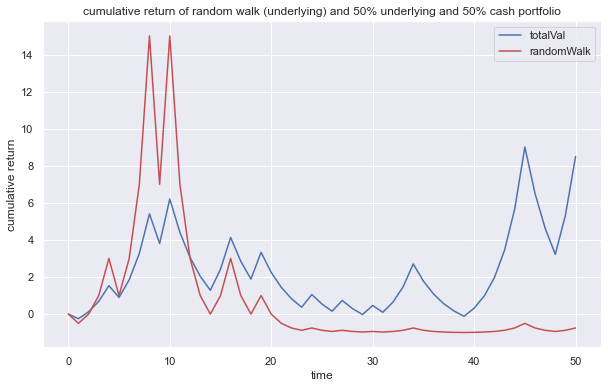

In [5]:
# plot results of portfolio and random walk
((outDf[['totalVal','randomWalk']].pct_change()+1).cumprod()-1).fillna(0).plot(kind='line',figsize=(10,6),
                                                                     title='cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio',
                                                                     xlabel='time',ylabel='cumulative return',color=['b','r'])

The random walk below is technically one sided in its variance, while there is an equal chance that it will either double or halve, the amount of change is unequal. This is shown in the bar plot below. 

<AxesSubplot:title={'center':'random walk bar plot of daily percent change'}, xlabel='time', ylabel='percent change'>

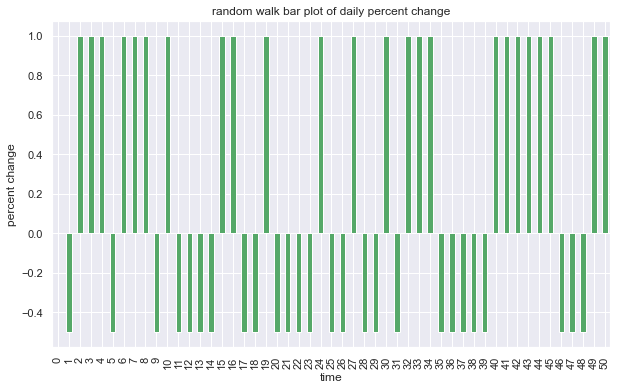

In [6]:
pd.Series(resArr).pct_change().fillna(0).plot(kind='bar',figsize=(10,6),title='random walk bar plot of daily percent change',color=['g'],xlabel='time',ylabel='percent change')

The follow up question is whether this still works on a random walk that is not one sided and is technically a martingale. There is a martingale betting strategy that involves betting more and more of the bankroll into a losing streak in blackjack and roulette. Conceptually the gambler knows that eventually the variance has to turn around and approach zero, thus by continually doubling down they can recoup their original investment. The important point around the martingale betting strategy is that you cant get an edge over the casino, you can just approach their theoretical edge. 

The way shannon backed into the 50% number above is from the discrete Kelly Criterion, since there is an equal chance that it moves 100% or -50%, you end up with a Kelly criterion of 50%. Note, for a true martingale random walk would have both an equal probability of directional movement but also an equal directional move. Said another way, the probability of a move in either direction and the theoretical move in either direction is both the same. The perfect example is a game where a coin is flipped and a winner is determined based on the face of the coin. 

The model above shows a true martingale random walk that has the same probability and size for both directions.

<AxesSubplot:title={'center':'Random walk, 50% chance to increase by 50%, 50% chance to decrease by 50%'}, xlabel='time', ylabel='value'>

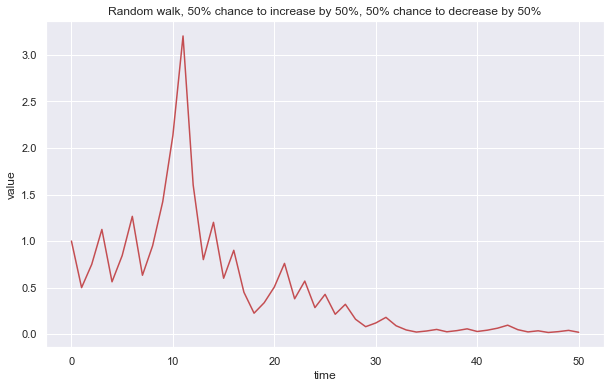

In [7]:
m2 = initModel(50,0.5,0.5)
pd.Series(m2).plot(kind='line',figsize=(10,6),
                       title='Random walk, 50% chance to increase by 50%, 50% chance to decrease by 50%',
                       xlabel='time',ylabel='value',color=['r'])

<AxesSubplot:title={'center':'cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio'}, xlabel='time', ylabel='cumulative return'>

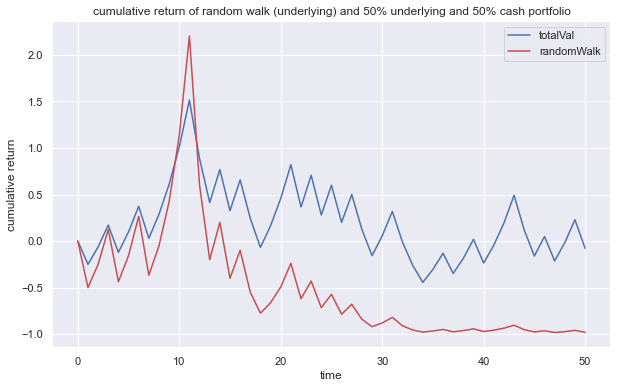

In [8]:
outDf = investmentModelCash(0.5,m2)
((outDf[['totalVal','randomWalk']].pct_change()+1).cumprod()-1).fillna(0).plot(kind='line',figsize=(10,6),
                                                                     title='cumulative return of random walk (underlying) and 50% underlying and 50% cash portfolio',
                                                                     xlabel='time',ylabel='cumulative return',color=['b','r'])

We can see from the plot above that the shannon demon portfolio strategy does not have a positive return in this example, below I try to quantiy this at a larger scale using Monte Carlo simulations. 

In [9]:
def runBulkSimulations(n,moveUp,moveDown,numberSims=1000):
    res = []
    for nc in range(numberSims):
        
        rand = initModel(n,moveUp,moveDown)
        
        port = investmentModelCash(0.5,rand)
        
        cumReturn = (port[['totalVal','randomWalk']].pct_change()+1).cumprod()-1
        
        res.append(cumReturn['totalVal'].iloc[-1])
        
    resArr = np.array(res)
    
    pctPos = len(resArr[resArr > 0]) / len(resArr)
    
    return pctPos

In [10]:
t = runBulkSimulations(200,1,0.5,1000)
print('Out of 1,000 simulations of 200 day equal probability 100% or -50% random walks, {}% were positive'.format(round(t*100,2)))

Out of 1,000 simulations of 200 day equal probability 100% or -50% random walks, 98.7% were positive


In [11]:
t2 = runBulkSimulations(200,0.5,0.5,1000)
print('Out of 1,000 simulations of 200 day equal probability 50% or -50% random walks, {}% were positive'.format(round(t2*100,2)))

Out of 1,000 simulations of 200 day equal probability 50% or -50% random walks, 3.7% were positive


We can see from the models above that given a larger sample size both in terms of length of the individual simulations and number of simulations considered, that the asymetric variance models combined with Shannon almost guarentee a profit. While the symmetric variance random walks (martingales) have a much smaller percentage that will likely approach zero given increasing sample size (sampling error). 

Another interesting question might be what does the cumulative return of the portfolio look like if there is a total negative cumulative return associated with the underlying. This is modeled below by forcing python to generate a random walk that had a negative cumulative return. 

In [28]:
n = 1
while n >= 0:
    resArr = initModel(50,1,0.5)
    cumReturn = ((pd.Series(resArr).pct_change()+1).cumprod()-1).fillna(0).values[-1]
    n = cumReturn

<AxesSubplot:title={'center':'Random walk (100% moves up, -50% moves down) over 50 days where cumulative return is negative'}, xlabel='time', ylabel='value'>

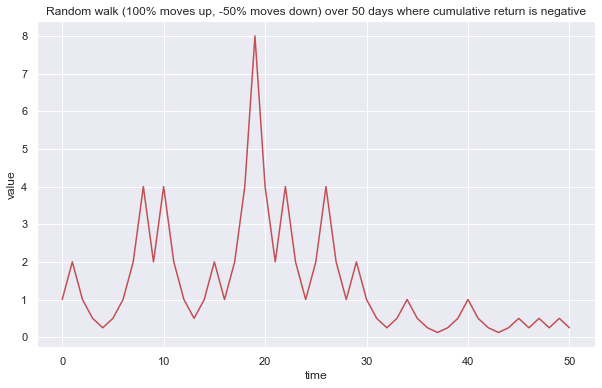

In [29]:
pd.Series(resArr).plot(kind='line',figsize=(10,6),title='Random walk (100% moves up, -50% moves down) over 50 days where cumulative return is negative',xlabel='time',ylabel='value',color=['r'])

<AxesSubplot:title={'center':'cumulative return of random walk (underlying) that ended negative and Shannon portfolio'}, xlabel='time', ylabel='cumulative return'>

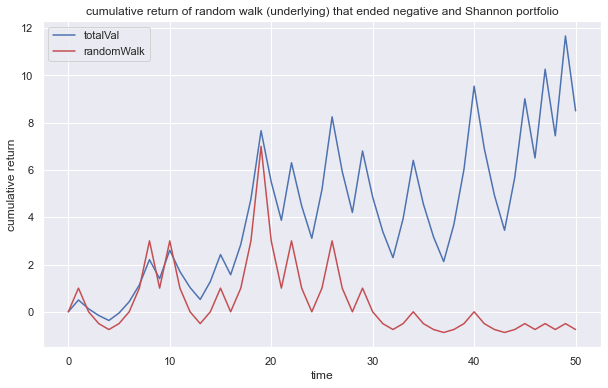

In [30]:
outDf = investmentModelCash(0.5,resArr)
((outDf[['totalVal','randomWalk']].pct_change()+1).cumprod()-1).fillna(0).plot(kind='line',figsize=(10,6),
                                                                     title='cumulative return of random walk (underlying) that ended negative and Shannon portfolio',
                                                                     xlabel='time',ylabel='cumulative return',color=['b','r'])

The model above shows that even when the underlying has a negative total return, the Shannon's Demon portfolio is still able to extract a positive portfolio return. 